In [1]:
# imports
from copy import deepcopy
import numpy as np
from statistics import mean

import sys
sys.path.append('../src/')

from classification import get_stumps
from evaluation import central_train_accuracy, central_test_accuracy, edges, central_loss, kalo_objective
from network import synthetic_graph, get_alphas
from related_works import colearning, lafond_FW
from optimization import local_FW, global_regularized_local_FW, gd_reg_local_FW, centralized_FW, regularized_local_FW
from utils import generate_models, generate_moons, get_min_max

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# set graph of nodes with local personalized data
NB_ITER = 3000
K = 20
D = 20
n = 200
NOISE_R = 0.05
random_state = 2017

MU = 0.1
BETA = 10

V, theta_true, _, angles = generate_models(nb_clust=1, nodes_per_clust=K, random_state=random_state, get_angles=True)
_, X, Y, X_test, Y_test, max_nb_instances = generate_moons(V, theta_true, D, random_state=random_state, sample_error_rate=NOISE_R)

# set graph
nodes, adj_matrix, similarities = synthetic_graph(X, Y, X_test, Y_test, V, theta_true, max_nb_instances)

# set monitors for optimization analysis
checkevery = 20
monitors = {
    'train-accuracy': [central_train_accuracy, []],
    'test-accuracy': [central_test_accuracy, []],
    'loss': [central_loss, []],
}

# get weak classifiers
vmin, vmax = get_min_max(X)
base_clfs = get_stumps(n=n, d=D+1, min_v=vmin, max_v=vmax)

results = {}

In [3]:
nodes_copy = deepcopy(nodes)
results["Dada exponential"] = regularized_local_FW(nodes_copy, base_clfs, beta=BETA, nb_iter=NB_ITER, mu=MU, 
                                                   monitors=monitors, checkevery=checkevery)

In [4]:
centralized_nodes = deepcopy(nodes)
centralized_FW(centralized_nodes, base_clfs, beta=BETA, nb_iter=NB_ITER, monitors={})
results["global l1 Adaboost"] = {}
results["global l1 Adaboost"]["train-accuracy"] = central_train_accuracy(centralized_nodes)
results["global l1 Adaboost"]["test-accuracy"] = central_test_accuracy(centralized_nodes)

local_nodes = deepcopy(nodes)
local_FW(local_nodes, base_clfs, beta=BETA, nb_iter=NB_ITER, monitors={})
results["purely local models"] = {}
results["purely local models"]["train-accuracy"] = central_train_accuracy(local_nodes)
results["purely local models"]["test-accuracy"] = central_test_accuracy(local_nodes)

global_nodes = deepcopy(nodes)
global_regularized_local_FW(global_nodes, base_clfs, beta=BETA, nb_iter=NB_ITER, monitors={})
results["global-local mixture"] = {}
results["global-local mixture"]["train-accuracy"] = central_train_accuracy(global_nodes)
results["global-local mixture"]["test-accuracy"] = central_test_accuracy(global_nodes)

In [5]:
results["personalized linear"], clf_colearning = colearning(K, X, Y, X_test, Y_test, D, NB_ITER, adj_matrix, 
                            similarities, mu=1, max_samples_per_node=max_nb_instances, checkevery=checkevery)

In [6]:
MU, LA = 1, 0.01
gd_pace = 300

monitors = {
    'train-accuracy': [central_train_accuracy, []],
    'test-accuracy': [central_test_accuracy, []],
    'edges': [edges, []],
    'obj-function': [kalo_objective, [MU, LA]],
    'loss': [central_loss, []],
}

gd_nodes = deepcopy(nodes)
results["Dada"] = gd_reg_local_FW(gd_nodes, base_clfs, gd_method={"name":"kalo", "pace_gd": gd_pace, 
        "args":(MU, LA)}, beta=BETA, mu=MU, nb_iter=NB_ITER, monitors=monitors, checkevery=checkevery)

# Accuracy and Convergence

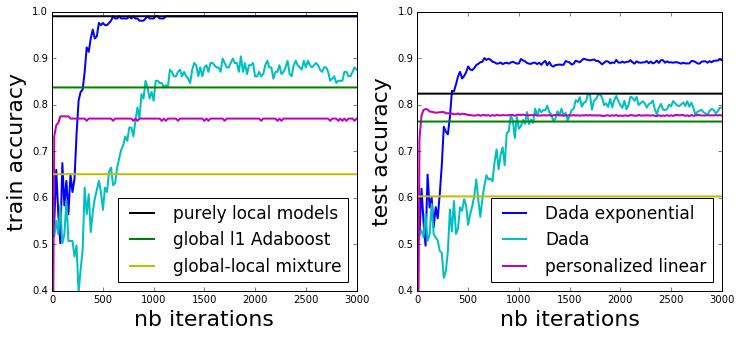

In [7]:
plt.figure(1, figsize=(12, 5))

colors = {
    "global l1 Adaboost": "g",
    "purely local models": "k",
    "Dada exponential": "b",
    "personalized linear": "m", 
    "Dada": "c",
    "global-local mixture": "y",
}

max_iter = NB_ITER
plt.subplot(121)
plt.xlabel('nb iterations', fontsize=22)
plt.ylabel('train accuracy', fontsize=22)
plt.xlim(0, max_iter)
plt.ylim(0.4, 1)

for k, r_list in results.items():
    label = k
    if k in ['Dada exponential', 'Dada', 'personalized linear']:
        label = '_nolegend_'
    try:
        plt.plot([i*checkevery for i in range(len(r_list))], [r['train-accuracy'] for r in r_list], label=label, color=colors[k], linewidth=2)
    except:
        plt.plot(range(NB_ITER+1), [r_list['train-accuracy']]*(NB_ITER+1), label=label, color=colors[k], linewidth=2)

plt.legend(loc='lower right', fontsize=17)

from matplotlib.legend import Legend

plt.subplot(122)
plt.xlabel('nb iterations', fontsize=22)
plt.ylabel('test accuracy', fontsize=22)
plt.xlim(0, max_iter)
plt.ylim(0.4, 1)

for k, r_list in results.items():
    label = '_nolegend_'
    if k in ['Dada exponential', 'Dada', 'personalized linear']:
        label = '{}'.format(k)
    try:
        plt.plot([i*checkevery for i in range(len(r_list))], [r['test-accuracy'] for r in r_list], label=label, color=colors[k], linewidth=2)
    except:
        plt.plot(range(NB_ITER+1), [r_list['test-accuracy']]*(NB_ITER+1), label=label, color=colors[k], linewidth=2)

plt.legend(loc='lower right', fontsize=17)

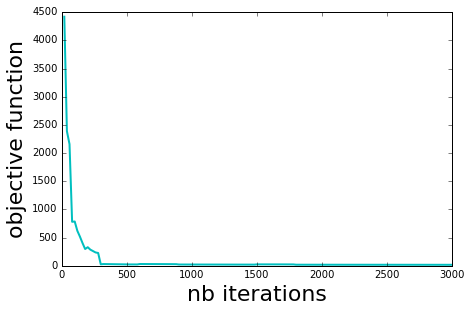

In [8]:
# convergence

max_iter = NB_ITER
plt.figure(1, figsize=(7, 10))

plt.subplot(211)
plt.xlabel('nb iterations', fontsize=22)
plt.ylabel('objective function', fontsize=22)

r_list = results["Dada"]
plt.plot([i*20 for i in range(len(r_list))], [r['obj-function'] for r in r_list], linewidth=2, color='c')

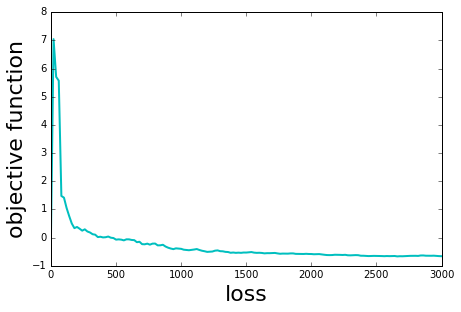

In [9]:
# convergence

max_iter = NB_ITER
plt.figure(1, figsize=(7, 10))

plt.subplot(211)
plt.xlabel('loss', fontsize=22)
plt.ylabel('objective function', fontsize=22)

r_list = results["Dada"]
plt.plot([i*20 for i in range(len(r_list))], [r['loss'] for r in r_list], linewidth=2, color='c')

Dada 3.5


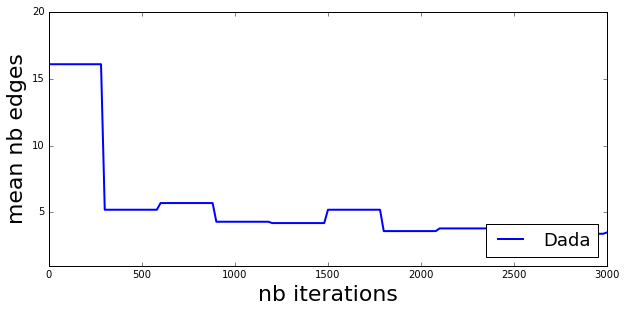

In [10]:
max_iter = NB_ITER
plt.figure(1, figsize=(10, 10))

plt.subplot(211)
plt.xlabel('nb iterations', fontsize=22)
plt.ylabel('mean nb edges', fontsize=22)
plt.xlim(0, max_iter)
plt.ylim(1, 20)

for k, r_list in results.items():
    try:
        print(k, np.mean(r_list[-1]['edges']))
        plt.plot([i*20 for i in range(len(r_list))], [np.mean(r['edges']) for r in r_list], label='{}'.format(k), linewidth=2)
    except:
        pass

plt.legend(loc='lower right', fontsize=18)

## Graph correlations

In [11]:
from scipy.stats import spearmanr

matrix_angles = np.empty((K, K))
for i in range(K):
    for j in range(K):
        matrix_angles[i, j] = abs(angles[i] - angles[j])

print("Correlation with angles")
print("kalo", spearmanr(matrix_angles, results["Dada"][-1]["similarities"], axis=None))
# print("uniform", spearmanr(matrix_angles, results_gd["uniform graph"][-1]["similarities"], axis=None))

print("\nCorrelation with similarities")
print("kalo", spearmanr(similarities, results["Dada"][-1]["similarities"], axis=None))
# print("uniform", spearmanr(similarities, results_gd["uniform graph"][-1]["similarities"], axis=None))

# print(matrix_angles)
print(np.sum(matrix_angles.T == matrix_angles) == K**2)

Correlation with angles
kalo SpearmanrResult(correlation=-0.1010768152331087, pvalue=0.04334328392257069)

Correlation with similarities
kalo SpearmanrResult(correlation=0.2937301399430462, pvalue=2.1135464598513717e-09)
True


In [12]:
def get_edges_weights(adj_matrix, similarities):
    edges = []
    weights = []
    for i in range(K):
        for j in range(i, K):
            if adj_matrix[i, j]:
                edges.append((i, j))
                weights.append(similarities[i, j])
    return edges, weights

In [13]:
import networkx as nx

STEP = gd_pace
kalo_graph = nx.from_numpy_matrix(results["Dada"][-1]["adj-matrix"])
kalo_edges, kalo_weights = get_edges_weights(results["Dada"][-1]["adj-matrix"], results["Dada"][-1]["similarities"])

groundtruth_graph = nx.from_numpy_matrix(adj_matrix)
gr_edges, gr_weights = get_edges_weights(adj_matrix, similarities)

pos = nx.spring_layout(kalo_graph)

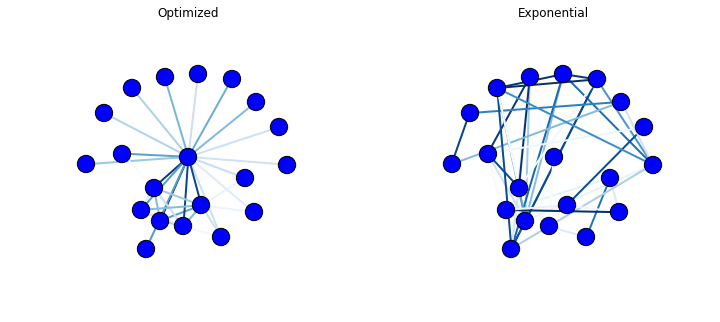

In [14]:
plt.figure(1, figsize=(12, 5))

plt.subplot(121)
plt.title('Optimized')
nx.draw(kalo_graph, pos, node_color='b', edgelist=kalo_edges, edge_color=kalo_weights, width=2.0, edge_cmap=plt.cm.Blues)

plt.subplot(122)
plt.title('Exponential')
nx.draw(groundtruth_graph, pos, node_color='b', edgelist=gr_edges, edge_color=gr_weights, width=2.0, edge_cmap=plt.cm.Blues)

## Accuracy vs sparsity


In [15]:
import itertools
LA_LIST = [j * 10**i for i in range(2) for j in range(1, 10)]
# LA_LIST = [10**i for i in range(-3, 3)]
# MU_LIST = [10**i for i in range(-3, 3)]

results_kalo = {}
# results_kalo = {}.fromkeys(itertools.product(MU_LIST, LA_LIST), {"train-accuracy": [], "test-accuracy": [], "mean-edges": []})
results_kalo = {}.fromkeys(LA_LIST, {"train-accuracy": [], "test-accuracy": [], "mean-edges": []})

NB_ITER = 3000

gd_pace = 300

for la in LA_LIST:
    
#     for mu in MU_LIST:
    print(la)
    results_kalo[la] = {"train-accuracy": [], "test-accuracy": [], "mean-edges": []}

    for _ in range(5):

        gd_nodes = deepcopy(nodes)
        gd_reg_local_FW(gd_nodes, base_clfs, gd_method={"name":"kalo", "pace_gd": gd_pace, "args":(MU, la)},
                        beta=BETA, mu=MU, nb_iter=NB_ITER, monitors={})

        results_kalo[la]["train-accuracy"].append(central_train_accuracy(gd_nodes))
        results_kalo[la]["test-accuracy"].append(central_test_accuracy(gd_nodes))        
        results_kalo[la]["mean-edges"].append(np.mean(edges(gd_nodes)))

0.001
0.003
0.005
0.007
0.009000000000000001
0.01
0.03
0.05
0.07
0.09
0.1
0.30000000000000004
0.5
0.7000000000000001
0.9
1
3
5
7
9
10
30
50
70
90
100
300
500
700
900


In [16]:
# sort results
for la in LA_LIST:
    results_kalo[la]["train-accuracy"] = np.mean(results_kalo[la]["train-accuracy"])    
    results_kalo[la]["test-accuracy"] = np.mean(results_kalo[la]["test-accuracy"])
    results_kalo[la]["mean-edges"] = np.mean(results_kalo[la]["mean-edges"])
    
train = {}
test = {}
for k, value in results_kalo.items():

    try:
        train[value["mean-edges"]].append(value["train-accuracy"])
    except:
        train[value["mean-edges"]] = [value["train-accuracy"]]
    
    try:
        test[value["mean-edges"]].append(value["test-accuracy"])
    except:
        test[value["mean-edges"]] = [value["test-accuracy"]]

train_sorted_keys = sorted(train.keys())    
test_sorted_keys = sorted(test.keys())  

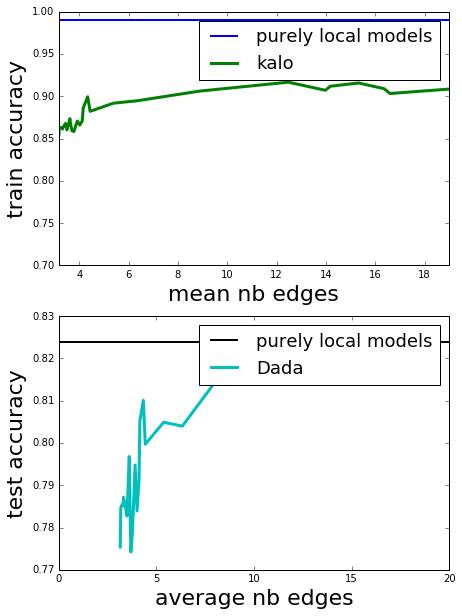

In [17]:
plt.figure(1, figsize=(7, 10))

plt.subplot(211)
plt.xlabel('mean nb edges', fontsize=22)
plt.ylabel('train accuracy', fontsize=22)


y = [np.mean(train[k]) for k in train_sorted_keys]
plt.plot([0,K], [results['purely local models']['train-accuracy']]*2, label='purely local models', linewidth=2)
plt.plot(train_sorted_keys, y, label='kalo', linewidth=3)
# plt.scatter([value[] for k, value in results_kalo.items()], [], linewidth=1)
plt.xlim(min(train_sorted_keys), max(train_sorted_keys))
plt.ylim(0.7, 1)

plt.legend(loc='upper right', fontsize=18)

plt.subplot(212)
plt.xlabel('average nb edges', fontsize=22)
plt.ylabel('test accuracy', fontsize=22)

y = [np.mean(test[k]) for k in test_sorted_keys]
plt.plot([0,K], [results['purely local models']['test-accuracy']]*2, label='purely local models', linewidth=2, color='k')
plt.plot(test_sorted_keys, y, label='Dada', linewidth=3, color='c')

# plt.xlim(min(test_sorted_keys), max(test_sorted_keys))
# plt.ylim(0.8, 0.9)

plt.legend(loc='upper right', fontsize=18)

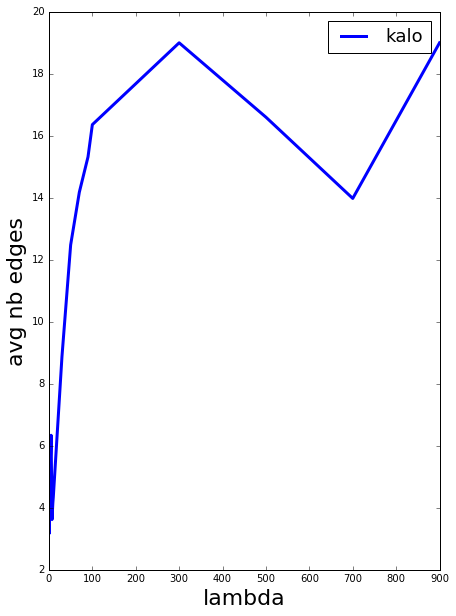

In [18]:
plt.figure(1, figsize=(7, 10))

plt.xlabel('lambda', fontsize=22)
plt.ylabel('avg nb edges', fontsize=22)

y = [np.mean(results_kalo[la]["mean-edges"]) for la in LA_LIST]
plt.plot(LA_LIST, y, label='kalo', linewidth=3)

plt.legend(loc='upper right', fontsize=18)